In [22]:
import mne
from meegkit.detrend import create_masked_weight, detrend
import os
import os.path as op
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from mne.decoding import GeneralizingEstimator, get_coef, LinearModel,cross_val_multiscore,SlidingEstimator
from src.decoding_functions import smooth_data
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
os.environ['MINDLABPROJ']='MINDLAB2020_MEG-AuditoryPatternRecognition'
os.environ['MNE_ROOT']='~/miniconda3/envs/mne' # for surfer
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.2'

In [3]:
wdir = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory'
raw_path = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/maxfiltered_data/tsss_st16_corr96'
ica_path = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/ICA'
avg_path = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages'
fwd_path = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/forward_models'
subjects_dir = '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/fs_subjects_dir'
sub = '0024_JSV'#'0031_WZD'#'0011_U7X'#'0002_TQ8' #0001_AF5 0003_BHS

blocks = ['main','inv']
types = ['listened','imagined']

srate = 100

# Parameters for smoothing
tstep = 0.025
twin = 0.05

In [37]:
## Define epochs for listened and imagined:        
events = {}
epochs = {}
for b in blocks: 
#    pass
    block_fname = os.path.join(raw_path, sub, b +'_raw_tsss.fif')
    icaname = os.path.join(ica_path,sub, b + '_raw_tsss-ica.fif')
    
    raw = mne.io.read_raw_fif(block_fname, preload = True) # load data
    ica = mne.preprocessing.read_ica(icaname) # load ica solution
    raw = ica.apply(raw) # apply ICA
    raw.pick_types(meg = True, eog = False, stim=True)
#     try:
#         raw.drop_channels(['MISC001','MISC002']) # delete audio channels
#     except:    
#         raw.drop_channels(['MISC002','MISC003'])
    raw.filter(None,40,fir_design = 'firwin')
    raw.resample(srate)
                
    events[b] = mne.find_events(raw, shortest_event = 1)
    events[b] = events[b][np.append(np.diff(events[b][:,0]) > 1,True)] # delete spurious t
    events[b + '_delay'] = events[b].copy()
    events[b][:,2] = events[b][:,2]%10 # recode events
    events[b+'_delay'] = events[b + '_delay'][events[b+'_delay'][:,2]<20,:]
    events[b+'_delay'][:,2] = events[b + '_delay'][:,2]%10
    events[b+'_fmel'] = events[b + '_delay'].copy()
    events[b+'_delay'][:,0] = events[b + '_delay'][:,0] + srate*2
    
    print('\nTrial masked robust detrending')
    sfreq = raw.info['sfreq']
    data = raw.get_data().T
    det_mask = create_masked_weight(data,np.array(events[b+'_fmel'][:,0]),tmin=0, tmax = 6.25, sfreq=sfreq)
    
    # Detrend per chunk
    cstart = 0
    nchunks = len(events[b+'_fmel'][:,0]) // 12
    for ck in range(nchunks):
        print('detrending chunk {}'.format(ck+1))
        if ck == nchunks - 1:
            cend = -1
        else:
            cend = int(np.round(events[b+'_fmel'][(ck+1)*12-1,0] + sfreq * 7.25)) + 1 
        data[cstart:cend,:],_,_ = detrend(data[cstart:cend,:],order=1,w=det_mask[cstart:cend])
        data[cstart:cend,:],_,_ = detrend(data[cstart:cend,:],order=30,w=det_mask[cstart:cend])
        cstart = cend + 1
        
    raw = mne.io.RawArray(data=data.T, info = raw.info.copy())
    #raw.filter(0.1,None,fir_design = 'firwin')
    
    print('epoching')
    event_id = {'1': 1, '2': 2, '3': 3}
    tmin, tmax = -0.1,0.5 #epoch time
    baseline = None#(-0.1,0) # baseline time
    reject = dict(mag = 4e-12, grad = 4000e-13)#, eog = 250e-6)
    
#     epochs[b] = mne.Epochs(raw, events = events[b], event_id = event_id,
#                     tmin = tmin, tmax = tmax,# picks = picks, 
#                     baseline = baseline)#,  decim = 1) #reject = reject,
    event_id2 = {'1':1,'3':3}
    epochs[b+'_delay'] = mne.Epochs(raw, events = events[b+'_delay'], event_id = event_id2,
                    tmin = -0.25, tmax = 2, #picks = picks, 
                    baseline = baseline)
    epochs[b+'_fmel'] = mne.Epochs(raw, events = events[b+'_fmel'], event_id = event_id2,
                tmin = -0.25, tmax = 2, #picks = picks, 
                baseline = baseline)
    
#     # Manual baseline correction
#     idx = [x and y for x,y in zip(epochs[b + '_fmel'].times >= -.1, epochs[b + '_fmel'].times <= 0)]
#     bmean = epochs[b + '_fmel'].get_data()[:,:,idx].mean(axis=2,keepdims=True)
#     epochs[b+'_delay'] = mne.EpochsArray(epochs[b+'_delay'].get_data() - bmean, info = epochs[b+'_delay'].info,
#                                          events = epochs[b+'_delay'].events, event_id = epochs[b+'_delay'].event_id,
#                                          tmin = epochs[b+'_delay'].tmin) #, tmax = 2)#, #picks = picks,                   baseline = baseline)
#     epochs[b+'_fmel'] = mne.EpochsArray(epochs[b+'_fmel'].get_data() - bmean, info = epochs[b+'_fmel'].info,
#                                         events = epochs[b+'_fmel'].events, event_id = epochs[b+'_fmel'].event_id,
#                                         tmin = epochs[b+'_fmel'].tmin)

Opening raw data file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/maxfiltered_data/tsss_st16_corr96/0024_JSV/main_raw_tsss.fif...
    Range : 9000 ... 581999 =      9.000 ...   581.999 secs
Ready.
Reading 0 ... 572999  =      0.000 ...   572.999 secs...
Reading /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/ICA/0024_JSV/main_raw_tsss-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- 

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/meegkit/utils/denoise.py:47: RuntimeWarning: invalid value encountered in true_divide
  mn = (np.sum(X * weights, axis=0) /


weights are all zero for channel 306
weights are all zero for channel 306
weights are all zero for channel 306


ValueError: array must not contain infs or NaNs

detrending chunk 1
detrending chunk 2
detrending chunk 3
detrending chunk 4
detrending chunk 5
detrending chunk 6


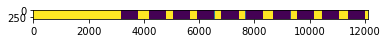

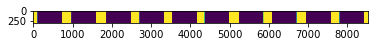

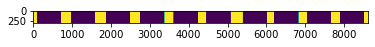

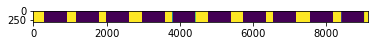

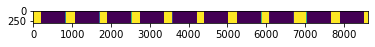

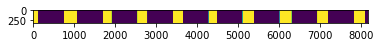

In [35]:
# for dch in range(det_mask.shape[1]):
#     print('\nchannel {}\n'.format(dch+1))
#     for dt in range(det_mask.shape[0]):
#         print(det_mask[dt,dch])
cstart = 0
nchunks = len(events[b+'_fmel'][:,0]) // 10
for ck in range(nchunks):
    print('detrending chunk {}'.format(ck+1))
    if ck == nchunks - 1:
        cend = -1#int(data.shape[0])
    else:
        cend = int(np.round(events[b+'_fmel'][(ck+1)*10-1,0] + sfreq * 7.25)) + 1 
    #print(det_mask[cstart:cend])
    plt.figure()
    plt.imshow(det_mask[cstart:cend].T)
    cstart = cend + 1

In [14]:
fwd_fn = op.join(fwd_path, sub + '_vol-fwd.fif')
fwd = mne.read_forward_solution(fwd_fn)
src_file = op.join(subjects_dir,sub,'bem',sub + '_vol-src.fif')
src = mne.read_source_spaces(src_file)

Reading forward solution from /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/forward_models/0024_JSV_vol-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13471 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Reading a source space...
    [done]
    1 source spaces read


In [15]:
gen_cnd = ['main_delay','inv_delay','main_fmel','inv_fmel']

In [16]:
# tstart, tend, tstep,Fs,taxis,twin = -.1, 6.25, .025, 100, 2, .05
# data = np.ones((200,1000,int(np.round(Fs*6.35))))
# new_data, ntime = smooth_data(data,tstart,tstep,twin,Fs,taxis)   
# print(new_data.shape)
# print(ntime)

KeyboardInterrupt: 

In [ ]:
# SNR = 3
# sources = {}
# # noise_cov = mne.compute_covariance([epochs[e].load_data().copy().pick_types('mag') for e in ['main_fmel','inv_fmel']],
# #                                     tmax=0., method=['shrunk', 'empirical'], rank='info', verbose=True)
# # fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

# data_cov = mne.compute_covariance([epochs[e].load_data().copy().pick_types('mag') for e in epochs],
#                                   tmin= 0,tmax = 4,rank ='info')
# # inverse solution
# inv = mne.beamformer.make_lcmv(epochs['main_delay'].info,fwd,data_cov, reg=0.05, pick_ori='max-power',
#                              #noise_cov=noise_cov,#pick_ori='max-power',depth = 0.95,
#                              weight_norm= 'nai', rank = 'info')


In [ ]:
#epochs['main_fmel'].average().pick('mag').plot_white(noise_cov,time_unit='s')

In [ ]:
# inv = mne.minimum_norm.make_inverse_operator(epochs['main_delay'].info, fwd, noise_cov, loose=0.2, depth=0.8)
# crop_times = {'main_delay': [-.25,2],'inv_delay': [-.25,2],'main_fmel': [-.25,1.5], 'inv_fmel': [-.25,1.5]}
# method = "dSPM"
# snr = 3.
# lambda2 = 1. / snr ** 2
# for e in epochs:
#     sources[e]={}
#     csource = mne.minimum_norm.apply_inverse_epochs(epochs[e].load_data().copy().crop(crop_times[e][0],crop_times[e][1]),
#                                                     inv,method=method,lambda2=lambda2)
#     sources[e] = np.array([cs.data for cs in csource])
#     print(sources[e].shape)
#     sources[e] = mne.filter.filter_data(sources[e], srate, None,4, n_jobs = 8)

In [17]:
SNR = 3
sources = {}
new_times = {}
data_cov = mne.compute_covariance([epochs[e].load_data().copy().pick_types('mag') for e in epochs],
                                  tmin= 0,tmax = 4,rank ='info')
## inverse solution
inv = mne.beamformer.make_lcmv(epochs['main_delay'].info,fwd,data_cov, reg=0.05, pick_ori='max-power',
                             #noise_cov=noise_cov,#pick_ori='max-power',depth = 0.95,
                             weight_norm= 'nai', rank = 'info')
crop_times = {'main_delay': [-.25,2],'inv_delay': [-.25,2],'main_fmel': [-.25,1.5], 'inv_fmel': [-.25,1.5]}

for e in gen_cnd:
    sources[e]={}
    csource = mne.beamformer.apply_lcmv_epochs(epochs[e].copy().crop(crop_times[e][0],crop_times[e][1]),inv,max_ori_out='signed')
    sources[e] = np.array([cs.data for cs in csource])
    sources[e], new_times[e] = smooth_data(sources[e], tstart=csource[0].tmin, tstep=tstep, twin=twin, Fs=srate, taxis=2)
    print(sources[e].shape)
    
    #sources[e] = mne.filter.filter_data(sources[e], srate, None,4, n_jobs = 8)

Computing rank from data with rank='info'
    MAG: rank 65 after 0 projectors applied to 102 channels


/tmp/ipykernel_14689/992275662.py:4: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  data_cov = mne.compute_covariance([epochs[e].load_data().copy().pick_types('mag') for e in epochs],


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 102 -> 65
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 48240
[done]
Computing rank from covariance with rank='info'
    MAG: rank 102 after 0 projectors applied to 102 channels
Computing rank from covariance with rank='info'
    MAG: rank 102 after 0 projectors applied to 102 channels
Making LCMV beamformer with rank {'mag': 102}
Computing inverse operator with 102 channels.
    102 out of 306 channels remain after picking
Selected 102 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 102}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 13471 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processin

In [ ]:
#sources = {g: sources[g] for g in sources}

In [ ]:
print(sources['main_delay'].shape)

In [21]:
gen ={}
patterns = {}
filters = {}

clf = make_pipeline(StandardScaler(),SelectKBest(f_classif, k=1000),
                    LinearModel(LogisticRegression(max_iter = 100000,solver='lbfgs')))
# clf = make_pipeline(StandardScaler(),SelectKBest(f_classif, k=1000),
#                     LinearModel(BernoulliNB()))
# clf = make_pipeline(StandardScaler(),SelectKBest(f_classif, k=1000),
#                     LinearModel(LinearSVC(max_iter = 100000)))
for g in gen_cnd:
    gen[g] = GeneralizingEstimator(clf, n_jobs=4, scoring = 'roc_auc') #scoring='roc_auc',
    #gen[g] =SlidingEstimator(clf, n_jobs=-1, scoring = 'accuracy') #scoring='roc_auc',
    gen[g].fit(X=sources[g],y=epochs[g].events[:, 2])
    pat = get_coef(gen[g],'patterns_',inverse_transform = True)
    fil = get_coef(gen[g],'filters_',inverse_transform = True)
    csource[0].tmin = new_times[g][0]
    csource[0].tstep = tstep
    patterns[g], filters[g] = csource[0].copy(), csource[0].copy()
    patterns[g].data = pat
    filters[g].data = fil

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

main_delay:
Transforming subject RAS (non-zero origin) -> MNI Talairach
     1.054230 -0.035701 -0.046767       0.81 mm
     0.040638  0.918992  0.270333     -36.04 mm
     0.027409 -0.203541  1.042355       0.15 mm
     0.000000  0.000000  0.000000       1.00

Showing: t = 0.887 s, (19.4, 12.2, -27.9) mm, [19, 28, 11] vox, 14868 vertex
Using control points [2.74461161 3.25505573 5.30519264]


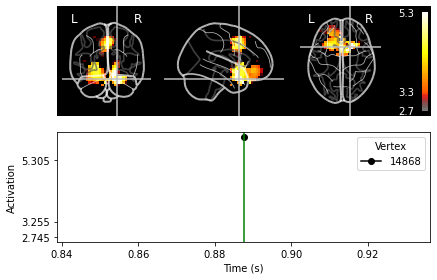

inv_delay:
Transforming subject RAS (non-zero origin) -> MNI Talairach
     1.054230 -0.035701 -0.046767       0.81 mm
     0.040638  0.918992  0.270333     -36.04 mm
     0.027409 -0.203541  1.042355       0.15 mm
     0.000000  0.000000  0.000000       1.00

Showing: t = 0.887 s, (14.4, 10.7, -33.3) mm, [18, 28, 10] vox, 13596 vertex
Using control points [1.73320554 2.07748539 6.0954203 ]


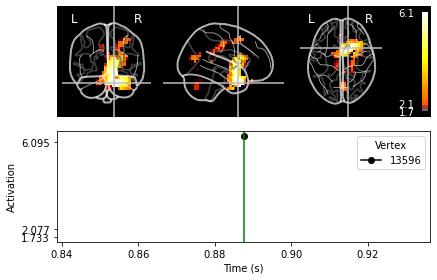

main_fmel:
Transforming subject RAS (non-zero origin) -> MNI Talairach
     1.054230 -0.035701 -0.046767       0.81 mm
     0.040638  0.918992  0.270333     -36.04 mm
     0.027409 -0.203541  1.042355       0.15 mm
     0.000000  0.000000  0.000000       1.00

Showing: t = 0.637 s, (29.2, -84.9, -28.3) mm, [20, 8, 7] vox, 9165 vertex
Using control points [1.3476187  1.52313326 3.10936614]


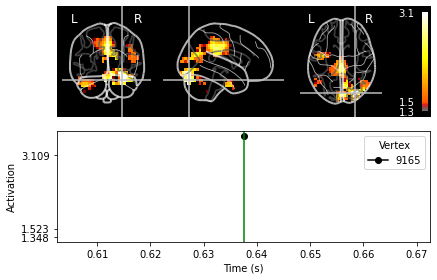

inv_fmel:
Transforming subject RAS (non-zero origin) -> MNI Talairach
     1.054230 -0.035701 -0.046767       0.81 mm
     0.040638  0.918992  0.270333     -36.04 mm
     0.027409 -0.203541  1.042355       0.15 mm
     0.000000  0.000000  0.000000       1.00

Showing: t = 0.637 s, (5.8, -68.9, 17.1) mm, [16, 9, 16] vox, 20631 vertex
Using control points [1.9971173  2.35809797 4.12422172]


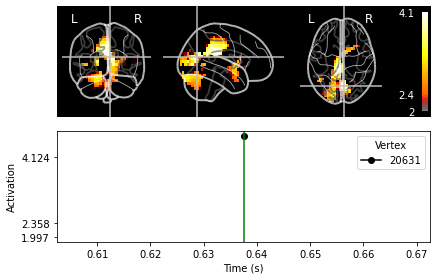

In [19]:
for p in patterns:
    print(p + ':')
    abs(patterns[p].copy().mean()).plot(src = src, subjects_dir = subjects_dir,mode='glass_brain')#[.007,.05,.023])

In [ ]:
# gen ={}
# patterns = {}
# filters = {}
# clf = make_pipeline(StandardScaler(),SelectKBest(f_classif, k=1000),
#                     LinearModel(LogisticRegression()))
# for g in gen_cnd:
#     gen[g] = GeneralizingEstimator(clf, n_jobs=4, scoring = 'roc_auc') #scoring='roc_auc',
#     #gen[g] =SlidingEstimator(clf, n_jobs=-1, scoring = 'accuracy') #scoring='roc_auc',
#     gen[g].fit(X=sources[g],y=epochs[g].events[:, 2])
#     pat = get_coef(gen[g],'patterns_',inverse_transform = True)
#     fil = get_coef(gen[g],'filters_',inverse_transform = True)
#     patterns[g], filters[g] = csource[0].copy(), csource[0].copy()
#     patterns[g].data = pat
#     filters[g].data = fil

In [ ]:
# print(sources['main_delay'].shape)

In [ ]:
# for p in patterns:
#     print(p + ':')
#     abs(patterns[p].copy().mean()).plot(src = src, subjects_dir = subjects_dir,mode='glass_brain')#[.007,.05,.023])

In [22]:
## get scores/accuracies:
#gen_cnd = ['main_delay','inv_delay']
scores = {}
for g1 in gen_cnd:
    for g2 in gen_cnd:
        nk = '{}_from_{}'.format(g1,g2)
        print(nk)
        if g1 == g2 : #if same data, use cross validation
            None
            scores[nk] = cross_val_multiscore(gen[g2], X=sources[g1],
                                              y=epochs[g1].events[:, 2],
                                              cv = 5,n_jobs = 1)
            scores[nk] = np.mean(scores[nk], axis = 0)
        else: # if different data, test in one, predict in the other
            if np.array_equal(np.unique(epochs[g1].events[:,2]),
                              np.unique(epochs[g2].events[:,2])):
               scores[nk]= gen[g2].score(X=sources[g1],
                                        y=epochs[g1].events[:, 2])

main_delay_from_main_delay


  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

main_delay_from_inv_delay


  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

main_delay_from_main_fmel


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

main_delay_from_inv_fmel


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

inv_delay_from_main_delay


  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

inv_delay_from_inv_delay


  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/89 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/7921 [00:00<?,       ?it/s]

inv_delay_from_main_fmel


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

inv_delay_from_inv_fmel


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

main_fmel_from_main_delay


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

main_fmel_from_inv_delay


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

main_fmel_from_main_fmel


  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

main_fmel_from_inv_fmel


  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

inv_fmel_from_main_delay


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

inv_fmel_from_inv_delay


  0%|          | Scoring GeneralizingEstimator : 0/6141 [00:00<?,       ?it/s]

inv_fmel_from_main_fmel


  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

inv_fmel_from_inv_fmel


  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/69 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/4761 [00:00<?,       ?it/s]

/tmp/ipykernel_14689/1616540403.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


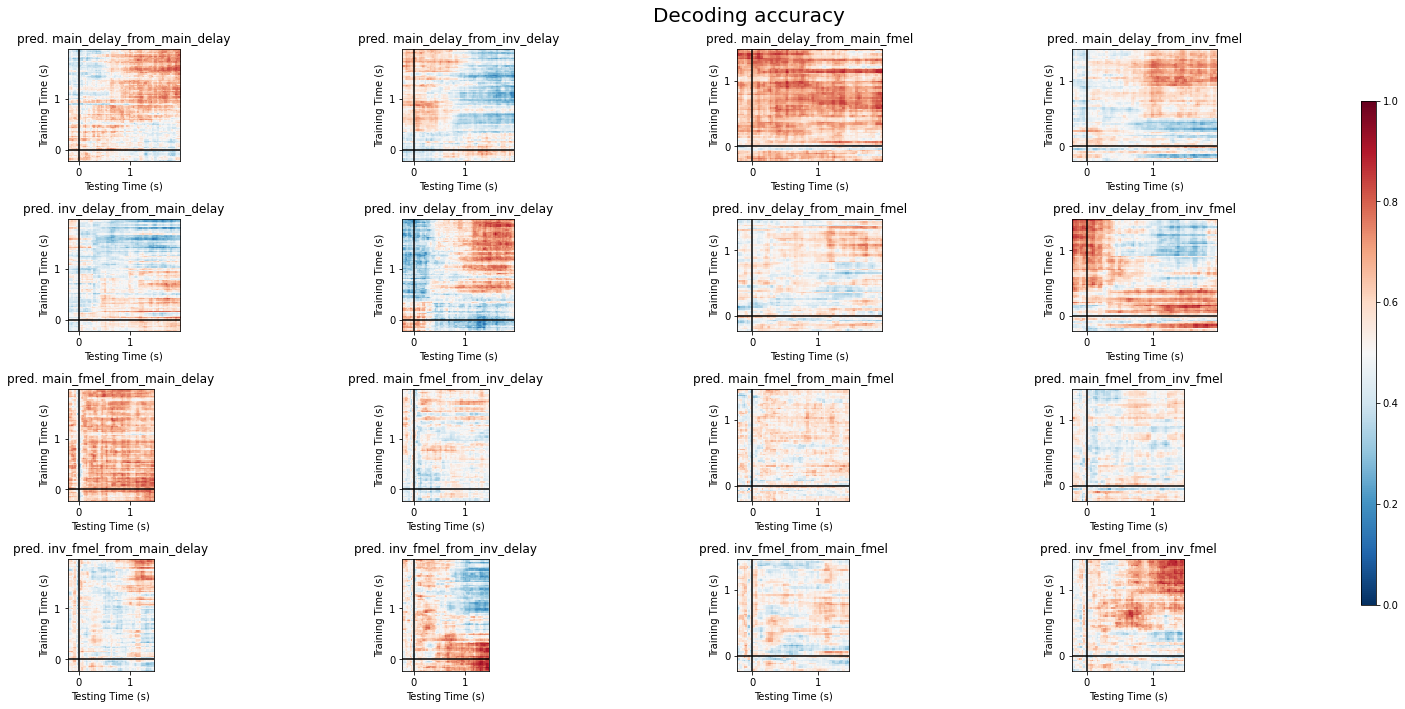

In [23]:
ncols = 4
fig, axes = plt.subplots(ncols=ncols,nrows=4, figsize = (20,10))#,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
for sidx,s in enumerate(scores):
    f,se = s.split('_from_')
    ext = [new_times[f][0],new_times[f][-1],
           new_times[se][0],new_times[se][-1]]
#     ext = [epochs[f].times[0],epochs[f].times[-1],
#            epochs[se].times[0],epochs[se].times[-1]]
    rix, cix = sidx//ncols,sidx%ncols
    im = axes[rix, cix].matshow(scores[s], vmin = 0, vmax = 1,#vmin=0.18, vmax=0.48,
                                      cmap='RdBu_r', origin='lower', extent=ext)
    axes[rix, cix].axhline(0., color='k')
    axes[rix, cix].axvline(0., color='k')
    axes[rix, cix].xaxis.set_ticks_position('bottom')
    axes[rix, cix].set_xlabel('Testing Time (s)')
    axes[rix, cix].set_ylabel('Training Time (s)')
    axes[rix, cix].set_anchor('W')
    axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
fig.colorbar(im,cax=cbar_ax)
fig.suptitle('Decoding accuracy', fontsize =  20)
plt.tight_layout()
plt.savefig(avg_path + '/figures/{}_accuracies1_smooth_baseline.pdf'.format(sub),orientation='landscape')
plt.show()

In [ ]:
# ncols = 2
# fig, axes = plt.subplots(ncols=ncols,nrows=2, figsize = (20,15))#,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
# for sidx,s in enumerate(scores):
#     f,se = s.split('_from_')
# #     ext = [epochs[f].times[0],epochs[f].times[-1],
# #            epochs[se].times[0],epochs[se].times[-1]]
#     rix, cix = sidx//ncols,sidx%ncols
#     axes[rix, cix].plot(epochs['main_delay'].times, scores[s])
#     axes[rix, cix].set_xlabel('Testing Time (s)')
#     axes[rix, cix].set_ylabel('Accuracy (s)')
# #     axes[rix, six].set_anchor('W')
#     axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})